# 4) Get Dividing Infrastructure 

## Env

In [41]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import os

### Mk SQL Connection

### Load from pickle


In [148]:
import pickle
# Load definitions

# Load 
with open('../data/temp/projections', 'rb') as fp:
    PROJ = pickle.load(fp)

# Load Definitions
with open('../data/temp/geo_definitions', 'rb') as fp:
    GEO_DEFINITIONS = pickle.load(fp)

## Get Hwys and Bridges

### First Load from Pickle

In [ ]:
# # Load each infrastructure
# hwys = {}
# bridges = {}

# # then load each 
# for m in ['chi','phi','nyc']:
#     print(f'Loading {m}..')
#     with open(f'../data/temp/osm_bridges_{m}', 'rb') as fp:
#         bridges[m] = pickle.load(fp)
#         print('\tbridges')
#     with open(f'../data/temp/osm_hwys_{m}', 'rb') as fp:
#         hwys[m] = pickle.load(fp)
#         print('\thwys')
    

### Bridges
`bridge in ['yes','viaduct']`

In [151]:
#ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'railway': 'rail', 'bridge': 'yes'}).groupby(['railway', 'bridge']).count()
#G_rail_bridges = ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'railway': 'rail'}).groupby('bridge').count()
#phi_feats = ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'bridge':['yes'})
#phi_feats.groupby(['element','highway']).count()
#phi_feats.plot()

bridges = {}
for m in GEO_DEFINITIONS.keys():
    print(f'{m}..')
    try:
        bridges[m] = ox.features_from_place(GEO_DEFINITIONS[m], tags={'bridge':['yes','viaduct']})
        with open(f'../data/temp/osm_bridges_{m}', 'wb') as fp:
            pickle.dump(bridges[m], fp)
        print(f'\tSuccess!')
    except Exception as e:
        print(f'\tError: {e}')

phi..
	Success!
chi..
	Success!
sf..
	Success!
sfba..
	Success!
eastbay..
	Success!
nyc..
	Success!


### Highways
`highway in ['motorway','motorway_link']`
`highway in ['motorway','motorway_link', 'motorway_junction']`

In [152]:
# Highways
HWY_DEFINITION = ['motorway','motorway_link','motorway_junctions']
#hwys = {}
for m in GEO_DEFINITIONS.keys():
    print(f'{m}..')
    try:
        #hwys[m] = ox.features_from_place(GEO_DEFINITIONS[m], tags={'highway':HWY_DEFINITION})
        with open(f'../data/temp/osm_hwys_{m}', 'wb') as fp:
            pickle.dump(hwys[m], fp)
        print(f'\tSuccess!')
    except Exception as e:
        print(f'\tError: {e}')
    

phi..
	Success!
chi..
	Success!
sf..
	Success!
sfba..
	Success!
eastbay..
	Success!
nyc..
	Success!


## Pipeline

### Get Bounds

In [154]:
GEO_DEFINITIONS

{'phi': [{'county': 'Philadelphia', 'state': 'Pennsylvania'}],
 'chi': [{'county': 'Cook', 'state': 'Illinois'}],
 'sf': [{'county': 'San Francisco', 'state': 'California'}],
 'sfba': [{'county': 'San Francisco', 'state': 'California'},
  {'county': 'Contra Costa', 'state': 'California'},
  {'county': 'Alameda', 'state': 'California'},
  {'county': 'San Mateo', 'state': 'California'},
  {'county': 'Santa Clara', 'state': 'California'}],
 'eastbay': [{'county': 'Contra Costa', 'state': 'California'},
  {'county': 'Alameda', 'state': 'California'}],
 'nyc': [{'county': 'King', 'state': 'New York'},
  {'county': 'Queens', 'state': 'New York'},
  {'county': 'New York', 'state': 'New York'},
  {'county': 'Bronx', 'state': 'New York'}]}

In [160]:
bounds = {}

for metro in ['phi','nyc','chi','sfba','sf','eastbay']:
    print(f'Loading {metro}..')
    try: 
        bounds[metro] = ox.geocoder.geocode_to_gdf(GEO_DEFINITIONS[metro]).dissolve()
        print('\tSuccess!')
    except Exception as e:
        print(f'\t{e}')


Loading phi..
	Success!
Loading nyc..
	Success!
Loading chi..
	Success!
Loading sfba..
	Success!
Loading sf..
	Success!
Loading eastbay..
	Success!


In [161]:
GEO_DEFINITIONS

{'phi': [{'county': 'Philadelphia', 'state': 'Pennsylvania'}],
 'chi': [{'county': 'Cook', 'state': 'Illinois'}],
 'sf': [{'county': 'San Francisco', 'state': 'California'}],
 'sfba': [{'county': 'San Francisco', 'state': 'California'},
  {'county': 'Contra Costa', 'state': 'California'},
  {'county': 'Alameda', 'state': 'California'},
  {'county': 'San Mateo', 'state': 'California'},
  {'county': 'Santa Clara', 'state': 'California'}],
 'eastbay': [{'county': 'Contra Costa', 'state': 'California'},
  {'county': 'Alameda', 'state': 'California'}],
 'nyc': [{'county': 'King', 'state': 'New York'},
  {'county': 'Queens', 'state': 'New York'},
  {'county': 'New York', 'state': 'New York'},
  {'county': 'Bronx', 'state': 'New York'}]}

### Project

In [182]:
# Pipeline Process
zones = {}

for m in ['phi','nyc','chi','sfba', 'sf','eastbay']:
    print(f'{m}...')
    # Union all together
    temp = pd.concat([hwys[m], bridges[m]], axis = 0)
    # - PROJECT to crs
    # - BUFFER (10m)
    temp['buffer10'] = temp.to_crs(PROJ[m]).buffer(10)
    temp = temp.set_geometry('buffer10')
    # - DISSOLVE into a singular geospatial object
    temp = temp.dissolve()
    # - DIFFERENCE between extents 
    # - MULTIPART_TO_SINGLEPARTS (explode)
    temp2 = bounds[m].to_crs(PROJ[m]).difference(temp).explode()
    # - CLIP by water and other boundaries (definitely necessary in NYC, unsure where else)
    zones[m] = temp2    

phi...
nyc...
chi...
sfba...
sf...
eastbay...


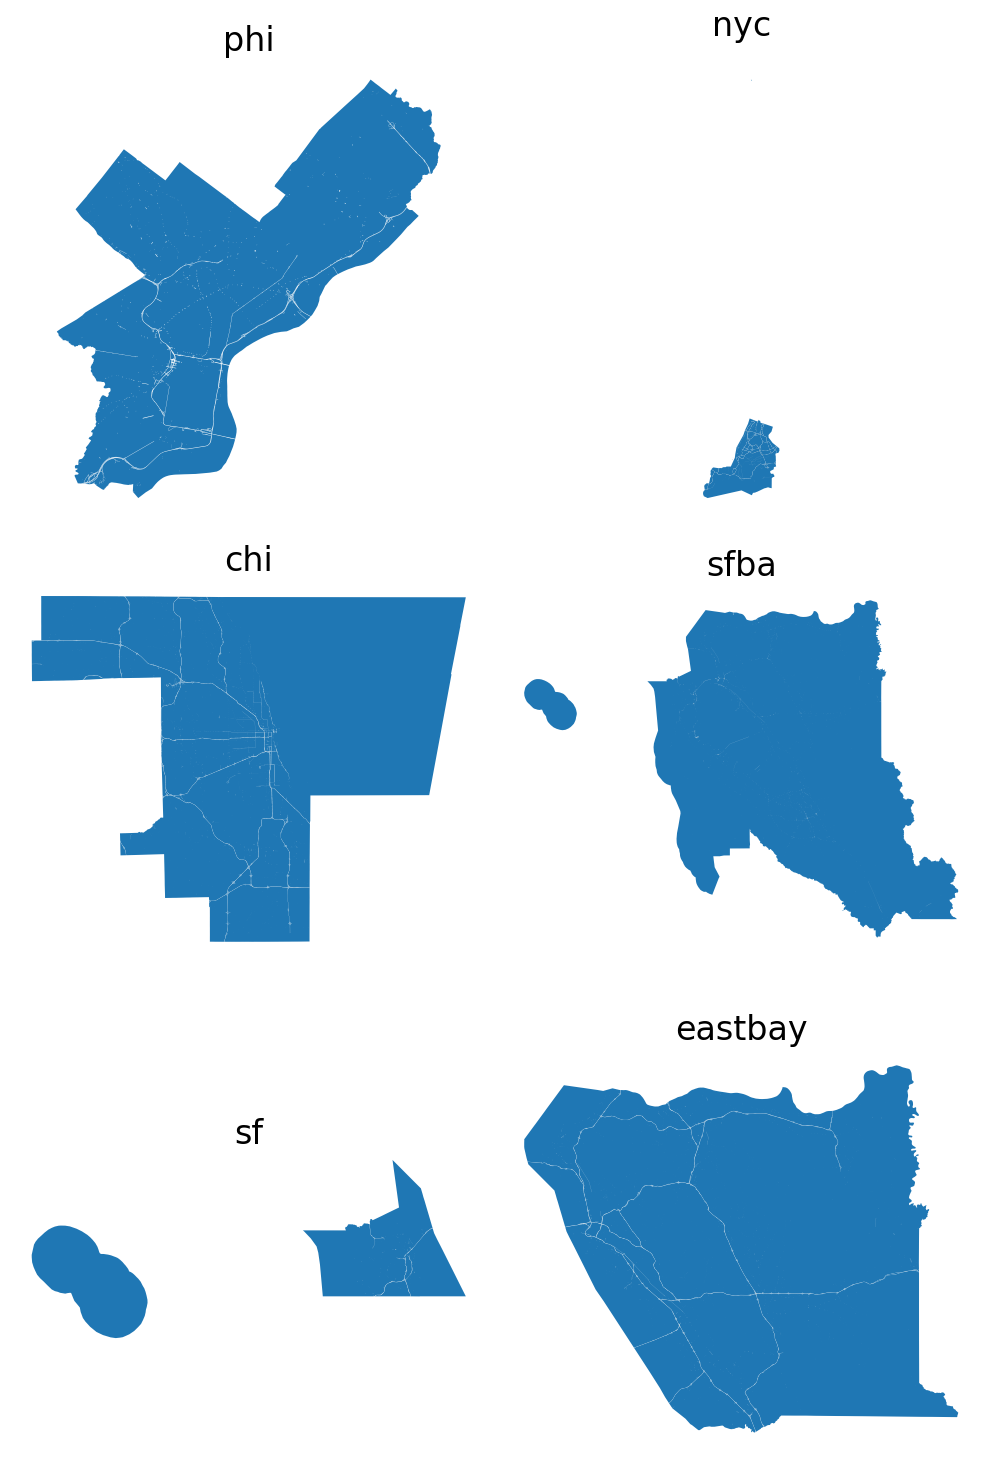

In [183]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(10,15))

axes = axes.flatten()

#for i, ax in enumerate(zip(ax, 
for i in zip(axes, zones.keys()):
    ax = i[0]
    m = i[1]
    
    zones[m].plot(ax=ax)
    ax.set_title(m, size = 24)
    ax.set_axis_off()

plt.tight_layout()
plt.show()
    

In [189]:
for i in zones.keys():
    print(f'{i}..')
    try:
        zones[i].to_file(f'../data/exported_zone_maps/{i}.shp')
        print(f'\tSuccess!')
    except Exception as e:
        print(f'\t{e}')

phi..
	Success!
nyc..
	Success!
chi..
	Success!
sfba..
	Success!
sf..
	Success!
eastbay..
	Success!
